In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

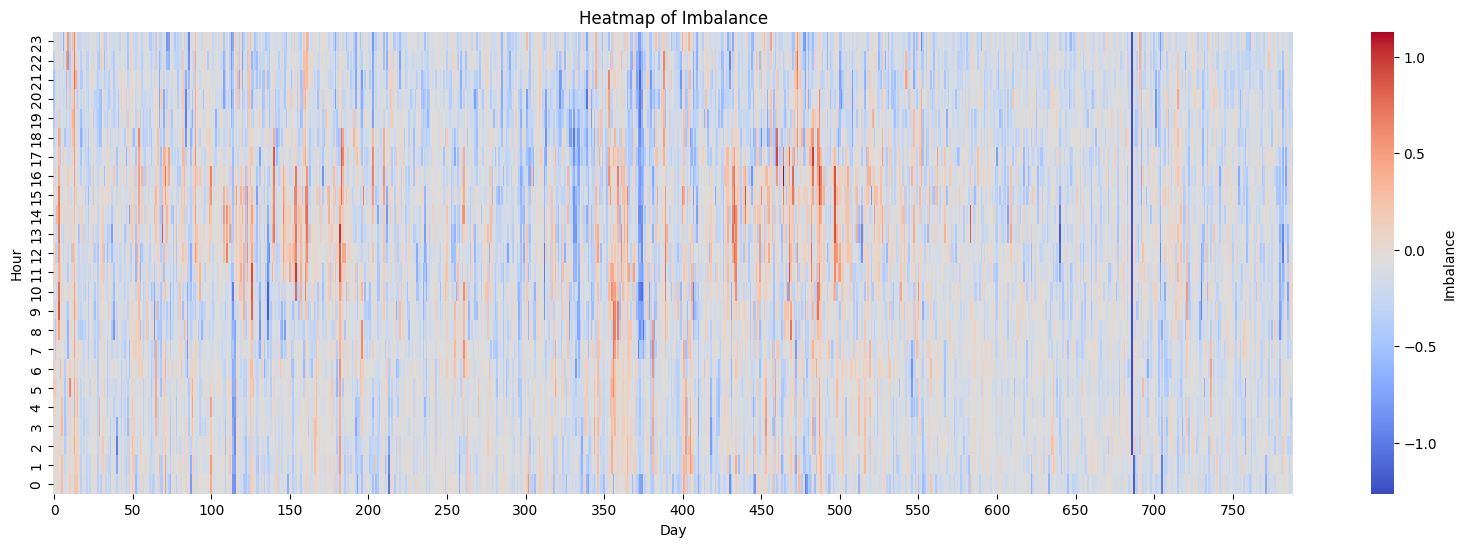

In [5]:
X = np.load("../data/X.npy")

condition = X[:, :3, :]
target = X[:, 3, :]

cond_tensor = torch.tensor(condition, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.float32)

dataset = TensorDataset(cond_tensor, target_tensor)

cond_dim = 3 * 24
target_dim = 24
latent_dim = 16

n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)


plt.figure(figsize=(20, 6))
ax = sns.heatmap(target.T, cmap='coolwarm', cbar_kws={'label': 'Imbalance'}, xticklabels=50)
ax.set_xlabel("Day")
ax.set_ylabel("Hour")
plt.title("Heatmap of Imbalance")
plt.gca().invert_yaxis()
plt.show()

In [6]:
class MLPBlock(nn.Module):
    def __init__(self, input_dim, dropout_prob=0.1):
        super(MLPBlock, self).__init__()
        inner_dim = 4 * input_dim 
        self.layer_norm = nn.LayerNorm(input_dim)
        self.fc1 = nn.Linear(input_dim, inner_dim)
        self.fc2 = nn.Linear(inner_dim, input_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        residual = x
        x = self.layer_norm(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x + residual

In [ ]:
class Encoder(nn.Module):
    def __init__(self, cond_dim, target_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(cond_dim + target_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
    
    def forward(self, cond, target):
        x = torch.cat([cond, target], dim=1)
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [ ]:
class Decoder(nn.Module):
    def __init__(self, cond_dim, latent_dim, target_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(cond_dim + latent_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, target_dim)
    
    def forward(self, cond, z):
        x = torch.cat([cond, z], dim=1)
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        out = self.fc3(h)
        return out

In [9]:
class CVAE(nn.Module):
    def __init__(self, cond_dim, target_dim, latent_dim):
        super(CVAE, self).__init__()
        self.encoder = Encoder(cond_dim, target_dim, latent_dim)
        self.decoder = Decoder(cond_dim, latent_dim, target_dim)
    
    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, cond, target):
        mu, logvar = self.encoder(cond, target)
        z = self.reparameterize(mu, logvar)
        recon_target = self.decoder(cond, z)
        return recon_target, mu, logvar

In [10]:
def loss_function(recon_target, target, mu, logvar):
    recon_loss = F.mse_loss(recon_target, target, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(cond_dim, target_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_cond, batch_target in train_loader:
        batch_cond = batch_cond.to(device)
        batch_target = batch_target.to(device)
        batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
        
        optimizer.zero_grad()
        recon_target, mu, logvar = model(batch_cond_flat, batch_target)
        loss = loss_function(recon_target, batch_target, mu, logvar)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item() * batch_cond.size(0)
    
    avg_train_loss = train_loss / len(train_dataset)

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_cond, batch_target in val_loader:
            batch_cond = batch_cond.to(device)
            batch_target = batch_target.to(device)
            batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
            recon_target, mu, logvar = model(batch_cond_flat, batch_target)
            loss = loss_function(recon_target, batch_target, mu, logvar)
            val_loss += loss.item() * batch_cond.size(0)
    avg_val_loss = val_loss / len(val_dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/100, Train Loss: 0.1355, Val Loss: 0.0620
Epoch 2/100, Train Loss: 0.0547, Val Loss: 0.0556
Epoch 3/100, Train Loss: 0.0508, Val Loss: 0.0535
Epoch 4/100, Train Loss: 0.0493, Val Loss: 0.0514
Epoch 5/100, Train Loss: 0.0482, Val Loss: 0.0510
Epoch 6/100, Train Loss: 0.0472, Val Loss: 0.0509
Epoch 7/100, Train Loss: 0.0467, Val Loss: 0.0499
Epoch 8/100, Train Loss: 0.0464, Val Loss: 0.0501
Epoch 9/100, Train Loss: 0.0460, Val Loss: 0.0491
Epoch 10/100, Train Loss: 0.0458, Val Loss: 0.0486
Epoch 11/100, Train Loss: 0.0455, Val Loss: 0.0492
Epoch 12/100, Train Loss: 0.0450, Val Loss: 0.0490
Epoch 13/100, Train Loss: 0.0447, Val Loss: 0.0484
Epoch 14/100, Train Loss: 0.0445, Val Loss: 0.0483
Epoch 15/100, Train Loss: 0.0440, Val Loss: 0.0482
Epoch 16/100, Train Loss: 0.0441, Val Loss: 0.0482
Epoch 17/100, Train Loss: 0.0438, Val Loss: 0.0482
Epoch 18/100, Train Loss: 0.0435, Val Loss: 0.0481
Epoch 19/100, Train Loss: 0.0434, Val Loss: 0.0483
Epoch 20/100, Train Loss: 0.0432, Val Lo

In [37]:
model.eval()
with torch.no_grad():
    sample_cond, sample_target = next(iter(val_loader))
    sample_cond_flat = sample_cond.view(sample_cond.size(0), -1).to(device)
    sample_target = sample_target.to(device)
    recon_target, _, _ = model(sample_cond_flat, sample_target)
    print("\nValidation Sample:")
    print("True Imbalance (first sample):")
    print(sample_target[0])
    print("Predicted Imbalance (random sample):")
    print(recon_target[0])

    


Validation Sample:
True Imbalance (first sample):
tensor([-0.0490,  0.0910,  0.0770,  0.0050,  0.0070, -0.1140, -0.0210,  0.2250,
         0.0000,  0.0680, -0.2050, -0.4580, -0.1760, -0.0800, -0.1530, -0.1750,
        -0.2560, -0.2320, -0.2170, -0.1510,  0.0350,  0.3190, -0.2310, -0.2190])
Predicted Imbalance (random sample):
tensor([-0.2145, -0.1573, -0.1270, -0.1189, -0.1186, -0.1201, -0.0845, -0.1344,
        -0.1463, -0.1391, -0.1453, -0.1050, -0.1524, -0.1584, -0.1791, -0.0736,
        -0.0947, -0.1489, -0.1773, -0.2067, -0.2293, -0.2559, -0.1804, -0.2081])


In [ ]:
model.eval()
with torch.no_grad():
    sample_cond, sample_target = next(iter(val_loader))
    sample_cond_flat = sample_cond.view(sample_cond.size(0), -1).to(device)
    sample_target = sample_target.to(device)
    
    mu, logvar = model.encoder(sample_cond_flat, sample_target)
    recon_target = model.decoder(sample_cond_flat, mu)
    
    print("\nValidation Samples and Predictions (First 5):")
    for i in range(5):
        print(f"\nSample {i+1} True Imbalance:")
        print(sample_target[i])
        print(f"Sample {i+1} Predicted Imbalance:")
        print(recon_target[i])



Validation Samples and Predictions (First 5):

Sample 1 True Imbalance:
tensor([-0.0490,  0.0910,  0.0770,  0.0050,  0.0070, -0.1140, -0.0210,  0.2250,
         0.0000,  0.0680, -0.2050, -0.4580, -0.1760, -0.0800, -0.1530, -0.1750,
        -0.2560, -0.2320, -0.2170, -0.1510,  0.0350,  0.3190, -0.2310, -0.2190])
Sample 1 Predicted Imbalance:
tensor([-0.2065, -0.1495, -0.1143, -0.1074, -0.1017, -0.1050, -0.0786, -0.1300,
        -0.1489, -0.1552, -0.1603, -0.1074, -0.1549, -0.1619, -0.1862, -0.0778,
        -0.1049, -0.1321, -0.1897, -0.2058, -0.2429, -0.2691, -0.1709, -0.2310])

Sample 2 True Imbalance:
tensor([-0.1760, -0.0070,  0.1670,  0.1440, -0.0310, -0.1520,  0.0040, -0.0260,
        -0.5200, -0.0880, -0.4040, -0.6700, -0.4890, -0.1120, -0.1170, -0.0830,
         0.0470,  0.1260, -0.2090, -0.3780, -0.0450, -0.0060, -0.1120, -0.1400])
Sample 2 Predicted Imbalance:
tensor([-1.0662e-01, -3.9600e-02,  2.4131e-02, -8.4778e-03, -4.5492e-02,
        -5.8022e-02, -7.0736e-02, -1.1229e-01